In [27]:
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import keras
import math
from sklearn.model_selection import KFold
import sklearn.metrics
from ann_visualizer.visualize import ann_viz
import graphviz
from sklearn.model_selection import train_test_split

In [28]:
# Number of epochs for neural network training
NUM_EPOCHS = 15

def get_model_1layer_final():
    # Neural Network Architecture for single sensor
    model = tf.keras.Sequential([
            layers.Dense(83, activation="relu", input_shape = (83,)),
            layers.Dense(64, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu"),
            layers.Dense(5, activation = 'softmax')])
    model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def clean_data(sensor, activity):
    data = pd.read_csv(sensor + ".csv", low_memory = False)
    # Take out unnamed columns
    data.drop([col for col in data.columns if "Unnamed" in col], axis=1, inplace = True)
    # Drop not encoded data
    data = data[data[activity] != 'private/not coded']
    return data


# Data Import

In [29]:
data = clean_data("thigh", "updated_final_activity")
used_cols = data.columns[18:(82 + 19)].tolist() + ['updated_final_activity']
used_data = data[used_cols]


X = used_data.drop("updated_final_activity", axis = 1)
y = used_data['updated_final_activity']

In [33]:
# Custom class for Ada-Boosting of a neural network

class Boosting:
    def __init__(self,dataset,T,test_dataset):
        self.dataset = dataset
        self.T = T
        self.test_dataset = test_dataset
        self.alphas = None
        self.models = None
        self.ensemble_preds = []
        self.class_labels = None
        
        self.model_correct = []
        
        self.tot_correct = 0
        self.total = 0
    def fit(self):
        # Set the descriptive features and the target feature
        X = self.dataset.drop(['updated_final_activity'],axis=1)
        X = X.fillna(X.mean()).values
        
        y = self.dataset['updated_final_activity']
        
        self.class_labels = pd.get_dummies(y).columns.tolist()
        Y = pd.get_dummies(y).values
        Evaluation = pd.DataFrame(y.copy())
        Evaluation['weights'] = 1/len(self.dataset) # Set the initial weights w = 1/N
        
        # Run the boosting algorithm by creating T "weighted models"
        
        alphas = [] 
        models = []
        
        # Train t estimators for the ensemmble
        
        for t in range(self.T):
            # Train the Neural Network
            nn = get_model_1layer_updated() 
            
            nn.fit(X, Y, batch_size = 128, epochs = NUM_EPOCHS, verbose = False) 
            
            # Append the single weak classifiers to a list which is later on used to make the 
            # weighted decision
            models.append(nn)
            
            # Get model predictions, save as list
            y_pred = np.argmax(nn.predict(X, verbose = 1), axis = 1)
            predictions = [self.class_labels[x] for x in y_pred.tolist()]
            #score = model.score(X,Y)
            # Add values to the Evaluation DataFrame
            Evaluation['predictions'] = predictions
            Evaluation['evaluation'] = np.where(Evaluation['predictions'] == Evaluation['updated_final_activity'],1,0)
            Evaluation['misclassified'] = np.where(Evaluation['predictions'] != Evaluation['updated_final_activity'],1,0)
            # Calculate the misclassification rate and accuracy
            accuracy = sum(Evaluation['evaluation'])/len(Evaluation['evaluation'])
            misclassification = sum(Evaluation['misclassified'])/len(Evaluation['misclassified'])
            # Caclulate the error
            err = np.sum(Evaluation['weights']*Evaluation['misclassified'])/np.sum(Evaluation['weights'])
 

            # Calculate the alpha values
            alpha = np.log((1-err)/err)
            alphas.append(alpha)
            # Update the weights wi --> These updated weights are used in the sample_weight parameter
            # for the training of the next decision stump. 
            Evaluation['weights'] *= np.exp(alpha*Evaluation['misclassified'])
            #print('The Accuracy of the {0}. model is : '.format(t+1),accuracy*100,'%')
            #print('The missclassification rate is: ',misclassification*100,'%')
        
        self.alphas = alphas
        self.models = models
    
    # Prediction that uses "majority rule" vote. Uses the error for each model as weights for each models input
    # on the final prediction
    def predict(self):
        X_test = self.test_dataset.drop(['updated_final_activity'],axis=1)
        Y_test = self.test_dataset['updated_final_activity']
        
        # With each model in the self.model list, make a prediction 
        
        accuracy = []
        predictions = []
        
        for alpha,model in zip(self.alphas,self.models):
            # Apply model weight to prediction        
            prediction = alpha * model.predict(X_test)
            predictions.append(prediction)
            # Make predictions with current number of models
            agg_predictions = np.sum(np.array(predictions),axis=0)
            preds = [np.argmax(np.where(p==np.max(p),1,0), axis = 0) for p in agg_predictions]
            pred_labels = np.array([self.class_labels[p] for p in preds])
            # Append predictions for current ensemble
            self.ensemble_preds.append(pred_labels)
            self.model_correct.append(np.sum(pred_labels == Y_test.values))
        
        # Update total predictions and correctly classified
        self.total = len(Y_test)
        

In [34]:

"""
Function for k-fold cross validation for an ensemble of feed forward neural networks
to determine accuracy. Makes an ensemble with n estimators for each kfold.

Parameters:
data(DataFrame): Dataframe with sensor data
splits(int): Number of splits for kfold cross validation
class_labels(list): List of strings containing the class labels for
    the classifier
cw(dict/None): Dictionary containing class weights for each class label,
    an be passed none for equal weighting

Returns:
list --> list of Boosting instances (ensembles) for each k-fold

"""
def run_kfold_ensemble(data, splits, num_estimators):
    kf = KFold(n_splits=splits)
    cnf_tables = []
    num_correct = 0
    num_total = 0
    ensembles = []
    
    for train_index, test_index, in kf.split(X):
        # Split data into train and test
        train, test = data.iloc[train_index], data.iloc[test_index]
        ensembles.append
        model = Boosting(train,num_estimators,test)
        model.fit()
        model.predict()
        ensembles.append(model)
    # Return ensemble of models for each kfold
    return ensembles
        

# Run Neural Network Ensemble, Graph Results

In [13]:
# Run k fold validation for ensemble
ensembles = run_kfold_ensemble(used_data, 10, 30)
test = ensembles[0]
test.model_correct[29]
num_estimators = 30

In [36]:
n_est_acc = []

# Calculate the kfold accuracy for each number of estimators in the ensemble
for n in range(num_estimators):
    kfold_correct = 0
    kfold_total = 0
    for kf in ensembles:
        kfold_correct += kf.model_correct[n]
        kfold_total += kf.total
    n_est_acc.append((n+1 ,kfold_correct/ kfold_total))
        
        
    

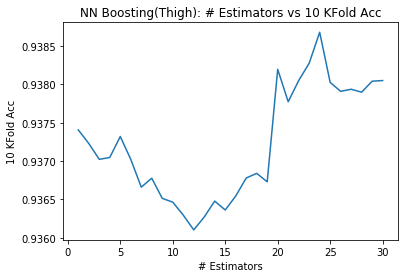

In [38]:
x = [a for (a,b) in n_est_acc]
y = [b for (a,b) in n_est_acc]
plt.title("NN Boosting(Thigh): # Estimators vs 10 KFold Acc")
plt.ylabel("10 KFold Acc")
plt.xlabel("# Estimators")
plt.plot(x,y)


Initialize all weights to $w = \frac{1}{n}$ where $n$ is the number of instances in the dataset

while $t$ < $T$ ($T$==number of models to be grown) do:
Create a model and get the hypothesis $h_t(x_n)$ for all datapoints $x_n$ in the dataset
Calculate the error $\epsilon$ of the training set summing over all datapoints $x_n$ in the training set with:
$$\epsilon_t \ \ = \ \ \ \frac{\sum_{n=1}^{N}w_n^{(t)}*I(y_n\neq h_t(x_n))}{\sum_{n=1}^{N}w_{n}^{(t)}}$$ where $I(cond)$ returns 1 if $I(cond)$ == True and 0 otherwise

Compute $\alpha$ with:
$$\alpha_t\ \ =\ \ \log(\frac{1-\epsilon_t}{\epsilon_t}) $$

Update the weights for the $N$ training instances in the next ($t+1$) model with:
$$w_{n}^{(t+1)}\ \ = \ \ w_{n}^{(t)}*exp(\alpha_t*I(y_n\neq h_t(x_n)))$$

After the $T$ iterations, calculate the final output with:
$$f(x)\ \ = \ \ sign(\sum_t^T \alpha_t*h_t(x))$$